In [2]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

# Constants for Solar Panel System
COST_PER_KW = 3150
NUM_YEARS = 20

# Constants for Grid System
sunlight_hours = {
    'jan': 2.08, 'feb': 3.06, 'mar': 3.9, 'apr': 5.05,
    'may': 6.02, 'jun': 6.35, 'jul': 6.34, 'aug': 5.52,
    'sep': 4.52, 'oct': 3.31, 'nov': 2.27, 'dec': 1.64
}

days_in_month = {
    'jan': 31, 'feb': 28, 'mar': 31, 'apr': 30,
    'may': 31, 'jun': 30, 'jul': 31, 'aug': 31,
    'sep': 30, 'oct': 31, 'nov': 30, 'dec': 31
}

MEAN_USAGE = 877
STD_DEV_MONTHLY = 50
NUM_MONTHS = 12
STD_DEV_DAILY = 100
degradation_rate = 0.01

monthly_usage = np.random.normal(MEAN_USAGE, STD_DEV_MONTHLY, NUM_MONTHS)
monthly_usage = np.sort(monthly_usage)[::-1]

months = {
    'jan': 7, 'feb': 8, 'mar': 10, 'apr': 11,
    'may': 4, 'jun': 3, 'jul': 1, 'aug': 2,
    'sep': 5, 'oct': 12, 'nov': 9, 'dec': 6
}

sorted_months = sorted(months, key=months.get)

monthly_usage = dict(zip(sorted_months, monthly_usage))

rates = {
    'jan': 0.2357, 'feb': 0.236, 'mar': 0.2118, 'apr': 0.1981,
    'may': 0.2047, 'jun': 0.2163, 'jul': 0.2227, 'aug': 0.2233,
    'sep': 0.2223, 'oct': 0.227, 'nov': 0.2272, 'dec': 0.2252
}


class EnergySystem:
    def __init__(self, rates, monthly_usage, std_dev_daily):
        self.rates = rates
        self.monthly_usage = monthly_usage
        self.std_dev_daily = std_dev_daily
        self.cost_of_system = 0
        self.cumulative_costs = [self.cost_of_system]
        self.monthly_demand_variability = {}
        self.monthly_peak_demand = {}

    def process_event(self, event):
        month = event['month']
        self.simulate_month(month)

    def simulate_energy_used(self, month):
        daily_usages = np.random.normal(self.monthly_usage[month] / days_in_month[month], self.std_dev_daily, days_in_month[month])
        month_used = np.sum(daily_usages)
        return daily_usages, month_used

    def simulate_month(self, month):
        raise NotImplementedError("Subclasses should implement this!")
    
    def store_demand_stats(self, month, daily_usages):
        self.monthly_demand_variability[month] = np.std(daily_usages)
        self.monthly_peak_demand[month] = np.max(daily_usages)

class SolarPanelSystem(EnergySystem):
    def __init__(self, kw_of_system, payment_method, annual_interest_rate, degradation_rate):
        super().__init__(rates, monthly_usage, STD_DEV_DAILY)
        self.kw_of_system = kw_of_system
        self.degradation_rate = degradation_rate
        self.cost_per_kw = COST_PER_KW
        self.cost_of_installation = self.kw_of_system * self.cost_per_kw
        self.fed_tax_credit = 0.30 * self.cost_of_installation
        self.ny_tax_credit = 5000 if self.cost_of_installation * 0.25 > 5000 else self.cost_of_installation * 0.25
        self.initial_cost = self.cost_of_installation - self.fed_tax_credit - self.ny_tax_credit
        self.payment_method = payment_method
        self.coned_cbc_charge = 1.09 * self.kw_of_system
        self.coned_cust_charge = 18
        self.excess = 0

        if self.payment_method == 'financed':
            self.monthly_payment = self.calculate_monthly_payment(self.initial_cost, annual_interest_rate, NUM_YEARS * 12)
            self.cost_of_system = 0
        elif self.payment_method == 'outright':
            self.cost_of_system = self.initial_cost
        else:
            raise ValueError('Invalid payment method. Please choose "financed" or "outright".')

        self.cumulative_costs = [self.cost_of_system]

    def process_event(self, event):
        month = event['month']
        self.simulate_month(month)

    def simulate(self, num_years, excess_handling):
        # Initialize event calendar with the first month
        event_calendar = [(i, {'month': month}) for i, month in enumerate(sorted_months)]
        heapq.heapify(event_calendar)  # Turn the list into a heap
    
        # Event processing loop
        while event_calendar:
            # Get the next event
            time, event = heapq.heappop(event_calendar)
        
            # Process the event
            self.process_event(event)
        
            # Generate new event (next year's month)
            if time < num_years * 12:
                new_event = (time + 12, {'month': event['month']})
                heapq.heappush(event_calendar, new_event)
        
            # Handle yearly excess
            if event['month'] == 'mar':
                self.handle_yearly_excess(excess_handling)
        
            # Collect statistics (e.g., cumulative costs)
            self.cumulative_costs.append(self.cost_of_system)
    
        # Return cumulative costs at the end of the simulation
        return self.cumulative_costs

    def calculate_monthly_payment(self, principal, annual_interest_rate, loan_term_in_months):
        """Calculate the monthly payment for a loan."""
        monthly_interest_rate = annual_interest_rate / 12
        monthly_payment = principal * (monthly_interest_rate * (1 + monthly_interest_rate)**loan_term_in_months) / ((1 + monthly_interest_rate)**loan_term_in_months - 1)
        return monthly_payment

    def simulate_month_generated(self, month):
        hours = np.random.normal(sunlight_hours[month], size=days_in_month[month])
        month_generated = np.sum(hours) * self.kw_of_system * (1 - self.degradation_rate)**(NUM_YEARS/12)
        return month_generated
    
    def simulate_month(self, month):
        month_generated = self.simulate_month_generated(month)
        daily_usages, month_used = self.simulate_energy_used(month)
        
        if month_generated > month_used:
            excess = month_generated - month_used
            self.excess += excess
        else:
            deficit = month_used - month_generated
            if self.excess >= deficit:
                self.excess -= deficit
                deficit = 0
            else:
                deficit -= self.excess
                self.excess = 0
            cost = deficit * rates[month]
            self.cost_of_system += cost

        self.cost_of_system += self.coned_cbc_charge
        self.cost_of_system += self.coned_cust_charge

        if self.payment_method == 'financed':
            self.cost_of_system += self.monthly_payment

        # Store variability and peak demand for the month
        self.store_demand_stats(month, daily_usages)

    def handle_yearly_excess(self, excess_handling):
        if excess_handling == 'payout':
            self.cost_of_system -= self.excess * 0.04
            self.excess = 0
        elif excess_handling == 'reset':
            self.excess = 0
        elif excess_handling == 'rollover':
            pass
        else:
            raise ValueError('Invalid excess handling method. Please choose "payout", "reset", or "rollover".')

class GridSystem(EnergySystem):
    def __init__(self, rates, monthly_usage, std_dev_daily):
        super().__init__(rates, monthly_usage, std_dev_daily)
        self.cost_of_system = 0
        self.cumulative_costs = [self.cost_of_system]

    def process_event(self, event):
        month = event['month']
        self.simulate_month(month)

    def simulate(self, num_years):
        # Initialize event calendar with the first month
        event_calendar = [(i, {'month': month}) for i, month in enumerate(sorted_months)]
        heapq.heapify(event_calendar)  # Turn the list into a heap

        # Event processing loop
        while event_calendar:
            # Get the next event
            time, event = heapq.heappop(event_calendar)

            # Process the event
            self.process_event(event)

            # Generate new event (next year's month)
            if time < num_years * 12:
                new_event = (time + 12, {'month': event['month']})
                heapq.heappush(event_calendar, new_event)

            # Collect statistics (e.g., cumulative costs)
            self.cumulative_costs.append(self.cost_of_system)

        # Return cumulative costs at the end of the simulation
        return self.cumulative_costs

    def simulate_month(self, month):
        daily_usages, month_used = self.simulate_energy_used(month)
        cost = month_used * self.rates[month]
        self.cost_of_system += cost

        # Store variability and peak demand for the month
        self.store_demand_stats(month, daily_usages)

In [ ]:
# Initialize SolarPanelSystem with parameters
system = SolarPanelSystem(8, 'financed', 0.15, degradation_rate)
grid_system = GridSystem(rates, monthly_usage, STD_DEV_DAILY)

# Simulate for the given number of years
cumulative_solar_costs = system.simulate(NUM_YEARS, 'rollover')
cumulative_grid_costs = grid_system.simulate(NUM_YEARS)

# Plot the cumulative costs for comparison
plt.figure(figsize=(8, 6))
plt.plot(cumulative_solar_costs, label='Solar Panel System')
plt.plot(cumulative_grid_costs, label='Grid System')
plt.xlabel('Year')
plt.ylabel('Cumulative Total Cost ($)')
plt.title('Cumulative Total Cost Comparison')
plt.legend()
plt.grid(True)
plt.show()

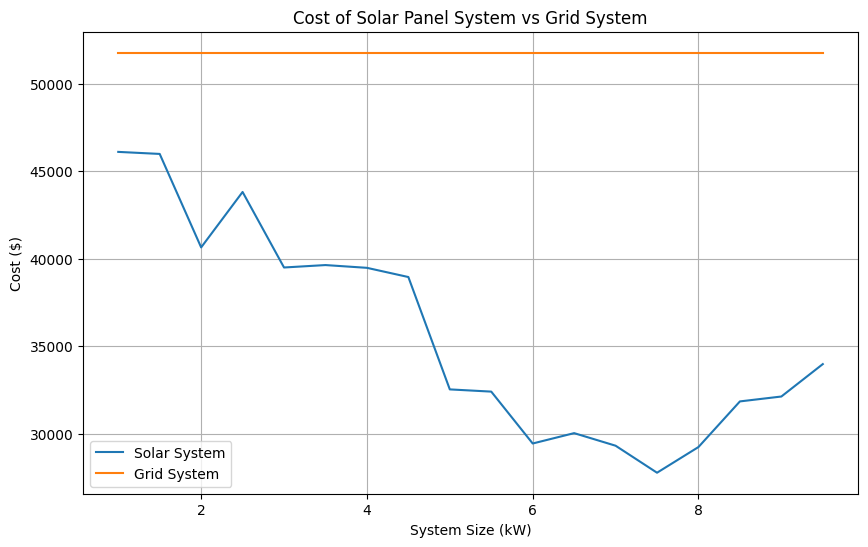

In [10]:
# Parameter sweep
system_sizes = np.arange(1, 10, 0.5)  # System sizes to sweep over
solar_costs = []  # List to store the final cost of the solar system for each size
grid_costs = []  # List to store the final cost of the grid system for each size

# Create a grid system
grid_system = GridSystem(rates, monthly_usage, STD_DEV_DAILY)
grid_system.simulate(NUM_YEARS)
grid_cost = grid_system.cumulative_costs[-1]
grid_costs = [grid_cost] * len(system_sizes)  # The cost of the grid system is the same for all system sizes

# Sweep over system sizes
for size in system_sizes:
    # Create a solar panel system
    solar_system = SolarPanelSystem(size, 'financed', 0.06, degradation_rate)
    solar_system.simulate(NUM_YEARS, 'payout')
    solar_cost = solar_system.cumulative_costs[-1]
    solar_costs.append(solar_cost)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(system_sizes, solar_costs, label='Solar System')
plt.plot(system_sizes, grid_costs, label='Grid System')
plt.xlabel('System Size (kW)')
plt.ylabel('Cost ($)')
plt.title('Cost of Solar Panel System vs Grid System')
plt.legend()
plt.grid(True)
plt.show()


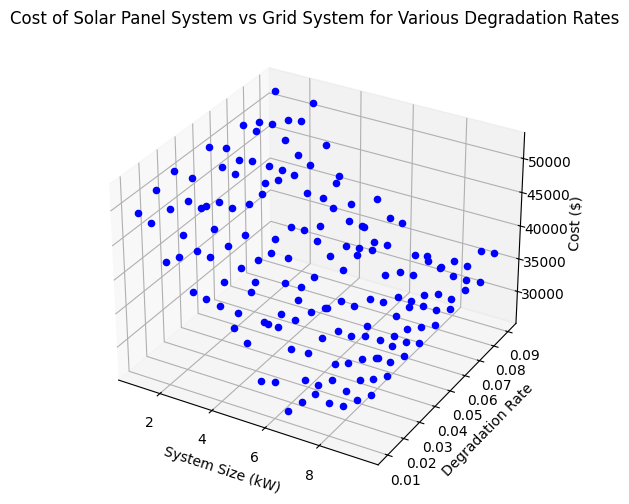

In [12]:
# Parameter sweep
system_sizes = np.arange(1, 10, 0.5)  # System sizes to sweep over
degradation_rates = np.arange(0.005, 0.05, 0.01)  # Degradation rates to sweep over

# Create a grid system
grid_system = GridSystem(rates, monthly_usage, STD_DEV_DAILY)
grid_system.simulate(NUM_YEARS)
grid_cost = grid_system.cumulative_costs[-1]

# Initialize a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Sweep over system sizes and degradation rates
for i, size in enumerate(system_sizes):
    for j, degradation_rate in enumerate(degradation_rates):
        # Create a solar panel system
        solar_system = SolarPanelSystem(size, 'financed', 0.06, degradation_rate)
        solar_system.simulate(NUM_YEARS, 'payout')
        solar_cost = solar_system.cumulative_costs[-1]
        
        # Plot the result
        ax.scatter(size, degradation_rate, solar_cost, color='b')
        #ax.scatter(size, degradation_rate, grid_cost, color='r')

# Set labels and title
ax.set_xlabel('System Size (kW)')
ax.set_ylabel('Degradation Rate')
ax.set_zlabel('Cost ($)')
ax.set_title('Cost of Solar Panel System vs Grid System for Various Degradation Rates')

# Show the plot
plt.show()


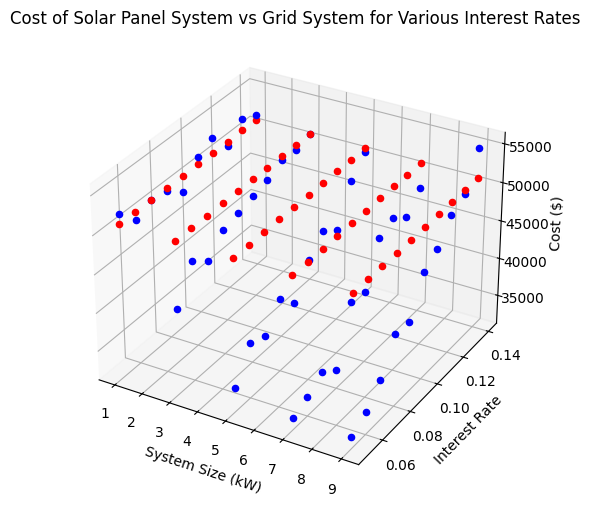

In [25]:
# Parameter sweep
system_sizes = np.arange(1, 10, 2)  # System sizes to sweep over
interest_rates = np.arange(0.05, 0.15, 0.01)  # Interest rates to sweep over

# Create a grid system
grid_system = GridSystem(rates, monthly_usage, STD_DEV_DAILY)
grid_system.simulate(NUM_YEARS)
grid_cost = grid_system.cumulative_costs[-1]

# Initialize a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Sweep over system sizes and interest rates
for i, size in enumerate(system_sizes):
    for j, interest_rate in enumerate(interest_rates):
        # Create a solar panel system
        solar_system = SolarPanelSystem(size, 'financed', interest_rate, degradation_rate)
        solar_system.simulate(NUM_YEARS, 'payout')
        solar_cost = solar_system.cumulative_costs[-1]
        
        # Plot the result
        ax.scatter(size, interest_rate, solar_cost, color='b')
        ax.scatter(size, interest_rate, grid_cost, color='r')

# Set labels and title
ax.set_xlabel('System Size (kW)')
ax.set_ylabel('Interest Rate')
ax.set_zlabel('Cost ($)')
ax.set_title('Cost of Solar Panel System vs Grid System for Various Interest Rates')

# Show the plot
plt.show()



In [ ]:
import graphviz

# Create a new graph
graph = graphviz.Digraph()

# Define nodes
graph.node('Start', 'Start Simulation')
graph.node('Event', 'Process Event')
graph.node('EnergyDemand', 'Simulate Energy Demand')
graph.node('SolarGeneration', 'Simulate Solar Generation')
graph.node('ExcessHandling', 'Handle Excess Energy')
graph.node('MonthlyCost', 'Calculate Monthly Costs')
graph.node('End', 'End Simulation')

# Define edges (connections)
graph.edge('Start', 'Event')
graph.edge('Event', 'EnergyDemand')
graph.edge('Event', 'SolarGeneration')
graph.edge('SolarGeneration', 'ExcessHandling')
graph.edge('EnergyDemand', 'ExcessHandling')
graph.edge('ExcessHandling', 'MonthlyCost')
graph.edge('MonthlyCost', 'Event', constraint='false')
graph.edge('Event', 'End')

# Display the graph
graph


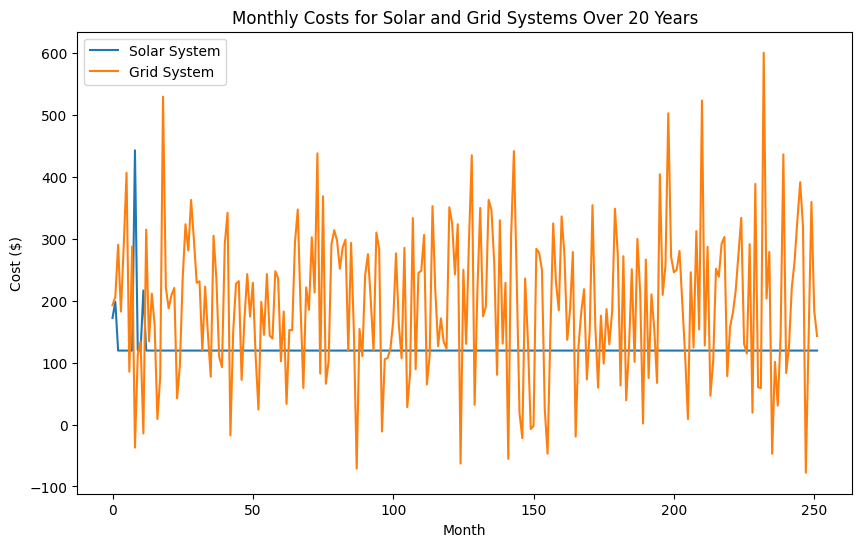

In [48]:
# Instantiate the systems
solar_system = SolarPanelSystem(7, 'financed', 0.09, 0.01)
grid_system = GridSystem(rates, monthly_usage, STD_DEV_DAILY)

# Simulate the systems
solar_costs = solar_system.simulate(NUM_YEARS, 'rollover')
grid_costs = grid_system.simulate(NUM_YEARS)

# Calculate monthly costs
solar_monthly_costs = [solar_costs[i] - solar_costs[i-1] for i in range(1, len(solar_costs))]
grid_monthly_costs = [grid_costs[i] - grid_costs[i-1] for i in range(1, len(grid_costs))]

# Generate the plot
plt.figure(figsize=(10, 6))
plt.plot(range((NUM_YEARS+1)*12), solar_monthly_costs, label='Solar System')
plt.plot(range((NUM_YEARS+1)*12), grid_monthly_costs, label='Grid System')
plt.xlabel('Month')
plt.ylabel('Cost ($)')
plt.title('Monthly Costs for Solar and Grid Systems Over 20 Years')
plt.legend()
plt.show()


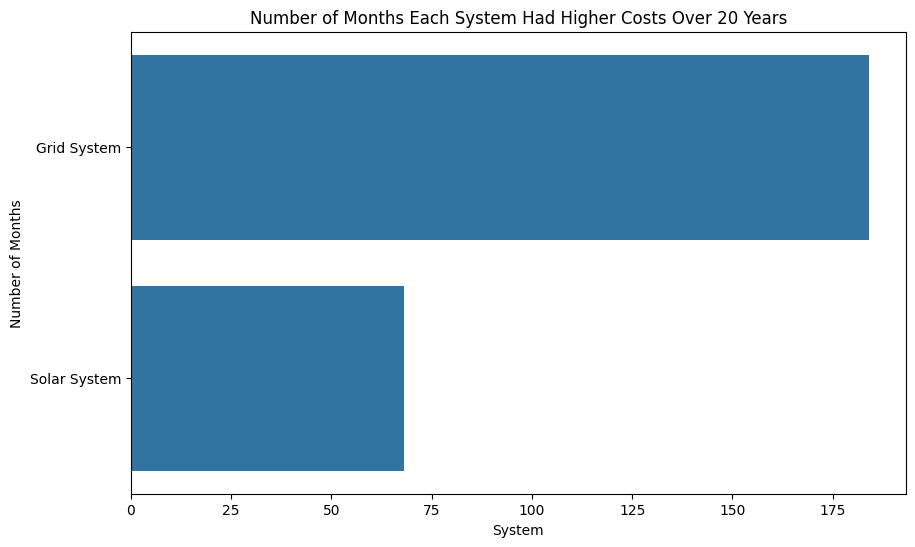

In [49]:
import seaborn as sns

# Determine which system had a higher cost each month
higher_cost_system = ['Solar System' if solar > grid else 'Grid System' 
                      for solar, grid in zip(solar_monthly_costs, grid_monthly_costs)]

# Generate the count plot
plt.figure(figsize=(10, 6))
sns.countplot(higher_cost_system)
plt.xlabel('System')
plt.ylabel('Number of Months')
plt.title('Number of Months Each System Had Higher Costs Over 20 Years')
plt.show()
